# Big Timber Time Lagged Guidance

Calculate the reliability of ProbGust, and previous guidance.

## Import modules

In [2]:
import xarray            as xr
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import scipy.stats       as stats
import pint

## Set some contants

In [3]:
sns.set_theme(color_codes=True)
units = pint.UnitRegistry()
hour = pd.to_timedelta('1H')
normal_distribution = stats.norm()

## Define utility functions

### correction
Apply operational correction to the time-lagged NAM proability for 6S0

In [4]:
def correction(criteria, value):
    new_value = value
    if criteria == 50:
        if value < 6:
            new_value = 0
        elif (6 <= value) and (value < 10):
            new_value = 15
        elif (10 <= value) and (value < 20):
            new_value = 25
        elif (20 <= value) and (value < 40):
            new_value = 60
        else:
            new_value = 90
    elif criteria == 58:
        if value < 10:
            new_value = 0
        elif (10 <= value) and (value < 20):
            new_value = 5
        elif (20 <= value) and (value < 40):
            new_value = 25
        else:
            new_value = 55
    elif criteria == 70:
        if value < 10:
            new_value = 0
        elif (10 <= value) and (value < 20):
            new_value = 0
        elif (20 <= value) and (value < 40):
            new_value = 2
        else:
            new_value = 10
    return new_value

### expand_timelag
Duplicate a dataframe while adjusting a datetime field by an interval to create a time-lagged dataset

In [5]:
def expand_timelag(df, interval, field='reference_time'):
    df2 = df.copy(deep=True).reset_index()
    df2[field] += pd.to_timedelta(interval)
    return df2

## Load Operation Probability Guidance

In [6]:
previous = xr.open_dataset('../data/database/K6S0model.nc').to_dataframe()
previous = previous.fillna(0)
previous = previous[(previous.model == 'NAM') & (previous.valid >= pd.to_datetime('2020-09-30T18:00:00Z').to_datetime64())][['run', 'valid', 'WrnProb']].sort_values(['valid', 'run']).reset_index(drop=True)
previous.columns = ['reference_time', 'valid_time', 'OriginalWarningProb_58']
previous = previous.set_index(['reference_time', 'valid_time'])
previous['TimeLaggedWarningProb_58'] = pd.concat([expand_timelag(previous, '{0:d}H'.format(i*6)) for i in range(12)]).groupby(['reference_time', 'valid_time']).mean()['OriginalWarningProb_58']
#previous.groupby(level='reference_time').apply(lambda s: s.rolling(window=12, min_periods=1).mean())['OriginalWarningProb_58']

for threshold in [50, 58, 70]:
    previous['Operational_{0:d}'.format(threshold)] = previous['TimeLaggedWarningProb_58'].apply(lambda a: correction(threshold, a))
previous

,,OriginalWarningProb_58,TimeLaggedWarningProb_58,Operational_50,Operational_58,Operational_70
reference_time,valid_time,,,,,
2020-09-27 06:00:00,2020-09-30 18:00:00,1.0,1.00,0,0,0
2020-09-27 12:00:00,2020-09-30 18:00:00,1.0,1.00,0,0,0
2020-09-27 18:00:00,2020-09-30 18:00:00,1.0,1.00,0,0,0
2020-09-28 00:00:00,2020-09-30 18:00:00,0.0,0.75,0,0,0
2020-09-28 18:00:00,2020-09-30 18:00:00,1.0,0.80,0,0,0
...,...,...,...,...,...,...
2021-03-22 18:00:00,2021-03-25 21:00:00,1.0,1.00,0,0,0
2021-03-22 12:00:00,2021-03-26 00:00:00,1.0,1.00,0,0,0
2021-03-22 18:00:00,2021-03-26 00:00:00,0.0,0.50,0,0,0


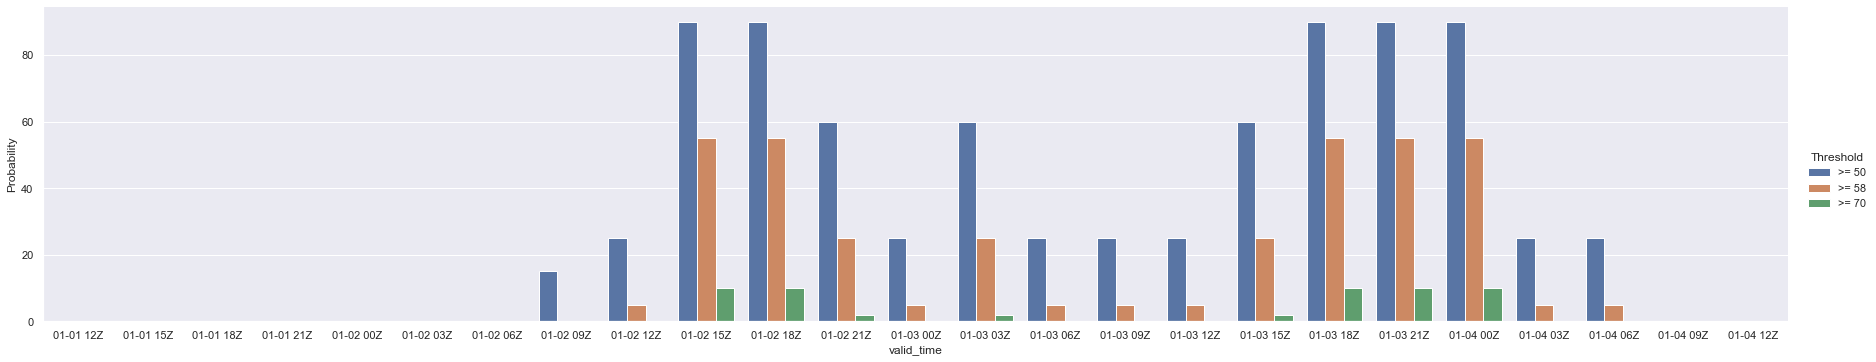

In [7]:
start = pd.to_datetime('2021-01-01T12:00:00Z')
end = start + pd.to_timedelta('3D')
run = previous[(previous.index.get_level_values(0) == start.to_datetime64()) * (previous.index.get_level_values(1) <= end.to_datetime64())].reset_index()
run = run[[x for x in run.columns if x.find('Operational') > -1 or x == 'valid_time']]
run.columns = [x.replace('Operational_', '>= ') for x in run.columns]
run = run.melt(id_vars='valid_time', value_name="Probability", var_name="Threshold")
run.valid_time = run.valid_time.dt.strftime('%m-%d %HZ')
g = sns.catplot(data=run, x='valid_time', y='Probability', hue='Threshold', kind='bar', aspect=5)
